In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import distributions as dist , norm
import seaborn as sns
import statsmodels.api as sm
import pandas_market_calendars as pmc
import pandas_datareader as web
from datetime import datetime
from dateutil.relativedelta import relativedelta
import scipy.stats as stats

In [217]:
# Import Weatherspoons share prices
today = datetime.today()
years = 5
start = today - relativedelta(years=years)
ticker = 'JDW.L'
df = web.DataReader(ticker, 'yahoo', start, today)

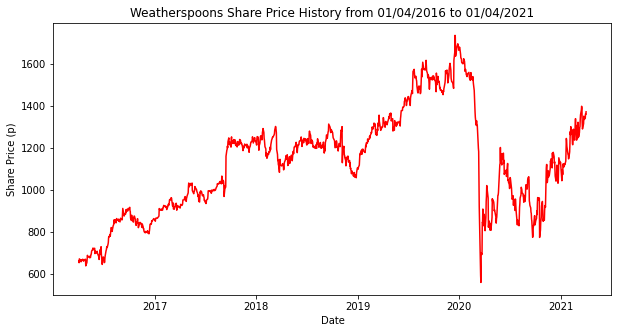

In [218]:
# Share Price against time

From = start
To = today

rest = df[From:To]

plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Share Price (p)')
plt.title(f'Weatherspoons Share Price History from {From.strftime("%d/%m/%Y")} to {To.strftime("%d/%m/%Y")}')
sns.lineplot(x = rest.index, y = rest['Adj Close'], color='red')
plt.show()

In [219]:
# Add daily returns column

l = list(df['Adj Close'])
l.insert(0,float('nan'))
l.pop()

log_df = df.copy()

df['Adj Close (Previous Day)'] = l
df['Daily Return %'] = (df['Adj Close'] - df['Adj Close (Previous Day)']) / df['Adj Close (Previous Day)'] * 100
df.dropna(axis=0, how='any', inplace=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close,Adj Close (Previous Day),Daily Return %
Date,,,,,,,,
2016-04-04,701.700012,679.5,701.0,691.0,291522.0,661.508728,669.646057,-1.215169
2016-04-05,694.268005,680.0,690.5,682.5,292979.0,653.371582,661.508728,-1.230089
2016-04-06,703.000000,678.0,683.0,701.5,482243.0,671.560730,653.371582,2.783890
2016-04-07,704.500000,690.5,702.0,700.0,225386.0,670.124634,671.560730,-0.213845
2016-04-08,702.500000,687.5,687.5,693.0,156450.0,663.423401,670.124634,-0.999998


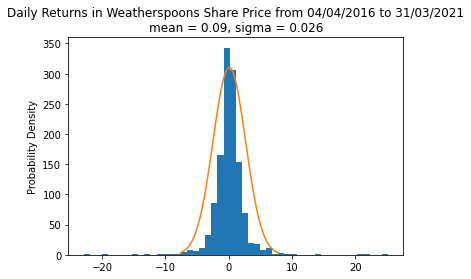

Annual drift of the stock is 22.59%
Annual Volatility of the stock is 40.84 %


In [220]:
From = start
To = today

df_cut = df[From:To]

mean = np.mean(df_cut['Daily Return %'])
std = np.std(df_cut['Daily Return %'])

drift_an = mean * 252
vol = std * np.sqrt(252)

x = np.linspace(mean - 3*std, mean + 3*std, 100)
fig, ax = plt.subplots()
ax.hist(df_cut['Daily Return %'], bins=50)
plt.ylabel('Probability Density')
plt.title(f'Daily Returns in Weatherspoons Share Price from {log_df_cut.index[0].strftime("%d/%m/%Y")} to {log_df_cut.index[-1].strftime("%d/%m/%Y")}\nmean = {round(mean, 3)}, sigma = {round(var, 3)}')
ax.plot(x, 2000 * stats.norm.pdf(x, mean, std))
plt.show()



print(f'Annual drift of the stock is {round(drift_an, 2)}%')
print(f'Annual Volatility of the stock is {round(vol, 2)} %')

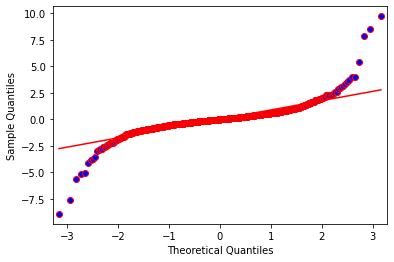

In [221]:
# QQ Plot for normal dist

From = '2016'
To = '2022'

data = df[From:To]['Daily Return %']

sm.qqplot(data, line='r', fit=True, color='r')
plt.show()

In [222]:
# Future Share Price Predictions function

def ds(price, interval, drift, vol, x=1):
    ds = drift * price * interval
    ds_worst = ds - (vol * np.sqrt(interval) * price * x)
    ds_best = ds + (vol * np.sqrt(interval) * price * x)
    s = price + ds
    worst = price + ds_worst
    best = price + ds_best
    return s, worst, best

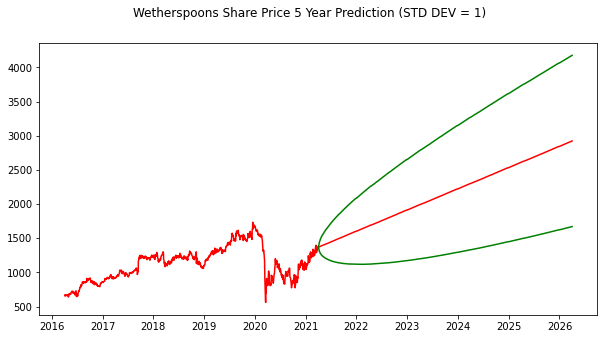

,High,Low,Open,Close,Volume,Adj Close,Adj Close (Previous Day),Daily Return %
Date,,,,,,,,
2016-04-04,701.700012,679.5,701.0,691.0,291522.0,661.508728,669.646057,-1.215169
2016-04-05,694.268005,680.0,690.5,682.5,292979.0,653.371582,661.508728,-1.230089
2016-04-06,703.000000,678.0,683.0,701.5,482243.0,671.560730,653.371582,2.783890
2016-04-07,704.500000,690.5,702.0,700.0,225386.0,670.124634,671.560730,-0.213845
2016-04-08,702.500000,687.5,687.5,693.0,156450.0,663.423401,670.124634,-0.999998


In [223]:
cal = pmc.get_calendar('LSE')
future = today + relativedelta(years=5)
schedule = cal.schedule(today, future)
dates = pmc.date_range(schedule, frequency='1D')

pred = []
maximum = []
minimum = []
dec_drift_an = drift_an / 100
dec_vol = vol / 100
std_devs = 1
for i in range(len(dates)):
    avg, worst, best = ds(df.iloc[-1]['Adj Close'], i/252, dec_drift_an, dec_vol, std_devs)
    pred.append(avg)
    maximum.append(best)
    minimum.append(worst)

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle(f'Wetherspoons Share Price 5 Year Prediction (STD DEV = {std_devs})')
ax.plot(df.index, df['Adj Close'], color='r')
ax.plot(dates, pred, color='r')
ax.plot(dates, maximum, color='g')
ax.plot(dates, minimum, color='g')
plt.show()
df.head()

A £1000000 investment in JDW.L shares on 2016-04-04 00:00:00 would have purchased 151169.6 shares
You could sell these shares today for £2071930.3, a 107.19% return on investment!
At the stock's lowest price on 19/03/2020, your investment would be worth £845793.83
At the stock's highest price on 17/12/2019, your investment would be worth £2621280.61
If you had left the money in a savings account at 0.77% interest p.a., it would now be worth £1039235.19,a 3.92% return on investment!


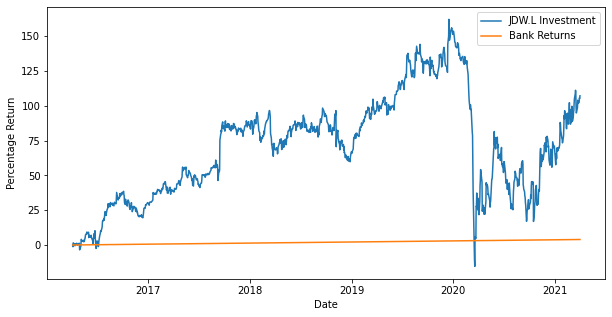

In [247]:
# £1M Investment Breakdown

investment = 1000000
investment_pence = investment * 100
date_bought = df.index[0]

# Import LIBOR interest rate data
LIBOR = 'LIBOR.csv'
lib_df = pd.read_csv(LIBOR, index_col='DATE')
lib_df.index = pd.to_datetime(lib_df.index)
interest_rate = float(lib_df.loc[lib_df.index >= date_bought].mean())

shares_bought = investment_pence / df.loc[date_bought,'Adj Close']
current_value = shares_bought * df.iloc[-1]['Adj Close'] / 100
per_return = (current_value - investment) / investment * 100
minimum_val = shares_bought * df.loc[date_bought:, 'Adj Close'].min() / 100
minimum_val_date = df['Adj Close'].idxmin()
maximum_val = shares_bought * df.loc[date_bought:, 'Adj Close'].max() / 100
maximum_val_date = df['Adj Close'].idxmax()
bank_value = investment * np.exp((interest_rate/100) * 5)
bank_return = (bank_value - investment) / investment * 100

print(f'A £{investment} investment in {ticker} shares on {date_bought} would have purchased {round(shares_bought,1)} shares')
print(f'You could sell these shares today for £{round(current_value,2)}, a {round(per_return,2)}% return on investment!')
print(f'At the stock\'s lowest price on {minimum_val_date.strftime("%d/%m/%Y")}, your investment would be worth £{round(minimum_val,2)}')
print(f'At the stock\'s highest price on {maximum_val_date.strftime("%d/%m/%Y")}, your investment would be worth £{round(maximum_val,2)}')
print(f'If you had left the money in a savings account at {round(interest_rate,2)}% interest p.a., it would now be worth £{round(bank_value,2)},a {round(bank_return,2)}% return on investment!')

# Plotting

percentage_return = list(((df['Adj Close'] / df.iloc[0]['Adj Close']) - 1) * 100)
bank_return_daily = []
for i in range(len(df.index)):
    bank_return_daily.append((np.exp((interest_rate/100) * i/252) - 1) * 100)
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('Date')
ax.set_ylabel('Percentage Return')
ax.plot(df.index, percentage_return, label=f'{ticker} Investment')
ax.plot(df.index, bank_return_daily, label='Bank Returns')
ax.legend()
plt.show()

In [225]:
# Lognormal Analysis

log_df['Log Returns'] = np.log(log_df['Adj Close'].pct_change() + 1)
log_df.dropna(how='any', axis=0, inplace=True)
log_df


,High,Low,Open,Close,Volume,Adj Close,Log Returns
Date,,,,,,,
2016-04-04,701.700012,679.500000,701.0,691.000000,291522.0,661.508728,-0.012226
2016-04-05,694.268005,680.000000,690.5,682.500000,292979.0,653.371582,-0.012377
2016-04-06,703.000000,678.000000,683.0,701.500000,482243.0,671.560730,0.027458
2016-04-07,704.500000,690.500000,702.0,700.000000,225386.0,670.124634,-0.002141
2016-04-08,702.500000,687.500000,687.5,693.000000,156450.0,663.423401,-0.010050
...,...,...,...,...,...,...,...
2021-03-26,1360.000000,1294.000000,1297.0,1336.000000,196949.0,1336.000000,0.001498
2021-03-29,1360.000000,1309.130005,1350.0,1339.000000,140084.0,1339.000000,0.002243
2021-03-30,1368.939941,1334.000000,1359.0,1361.000000,193884.0,1361.000000,0.016297


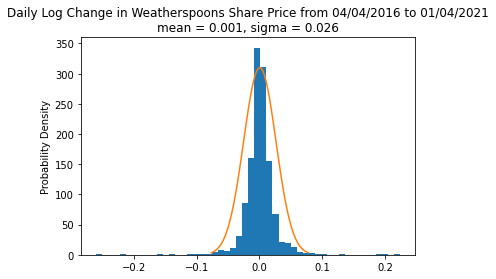

Annual drift of the stock is 14.26%
Annual Volatility of the stock is 40.86%


In [226]:
From = start
To = today

log_df_cut = log_df[From:To]
mean = np.mean(log_df_cut['Log Returns'])
std = np.std(log_df_cut['Log Returns'])

x = np.linspace(mean - 3*std, mean + 3*std, 100)

fig, ax = plt.subplots()
ax.hist(log_df_cut['Log Returns'], bins=50)
plt.ylabel('Probability Density')
plt.title(f'Daily Log Change in Weatherspoons Share Price from {log_df_cut.index[0].strftime("%d/%m/%Y")} to {log_df_cut.index[-1].strftime("%d/%m/%Y")}\nmean = {round(mean, 3)}, sigma = {round(std, 3)}')
ax.plot(x, 20 * stats.norm.pdf(x, mean, std))
plt.show()

drift_an = mean * 252
vol = std * np.sqrt(252)

print(f'Annual drift of the stock is {round(drift_an * 100, 2)}%')
print(f'Annual Volatility of the stock is {round(vol * 100, 2)}%')

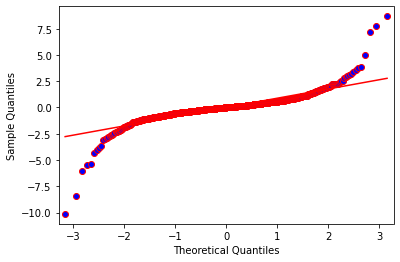

In [227]:
# Log QQ Plot

From = start
To = today

data = log_df[From:To]['Log Returns']

sm.qqplot(data, line='r', fit=True, color='r')
plt.show()

In [237]:
def share_price(initial, drift, vol, delta, x=1):
    s = np.exp(np.log(initial) + (drift_an * delta))
    best = np.exp(np.log(initial) + (drift_an * delta) + (vol * x * np.sqrt(delta)))
    worst = np.exp(np.log(initial) + (drift_an * delta) - (vol * x * np.sqrt(delta)))
    return s, best, worst

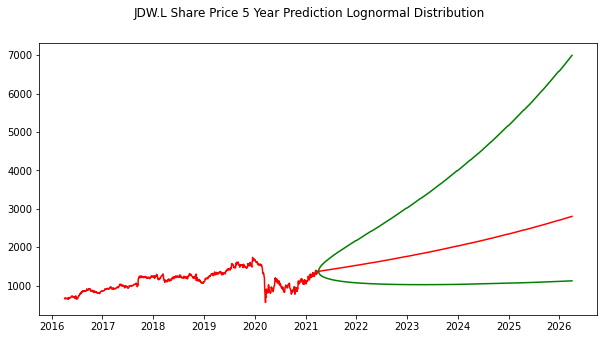

1370.5999755859375


In [241]:

price = []
best = []
worst = []
initial = df.iloc[-1]['Adj Close']
for i in range(len(dates)):
    price.append(share_price(initial, drift_an, vol, i/252)[0])
    best.append(share_price(initial, drift_an, vol, i/252)[1])
    worst.append(share_price(initial, drift_an, vol, i/252)[2])
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle(f'{ticker} Share Price 5 Year Prediction Lognormal Distribution')
ax.plot(df.index, df['Adj Close'], color='r')
ax.plot(dates, price, color='r')
ax.plot(dates, best, color='g')
ax.plot(dates, worst, color='g')
plt.show()